# Data Cleaning project- Nadir Nibras

### Taking a closer look at NYC High School Data, combining information from different datasets 

# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

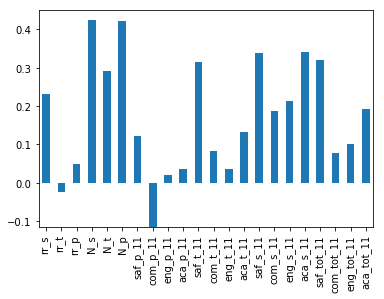

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

combined.corr()["sat_score"][survey_fields].plot.bar()


### Analysis
The number of participants for the survey are surprisingly correlated the most, which may suggest that bigger schools may perform better.

"Safety and respect" scores also seem to correlate.

Not surprisingly "Academic expectations score based on student responses" is also correalted with the SAT scores
# Investigating Safety scores further

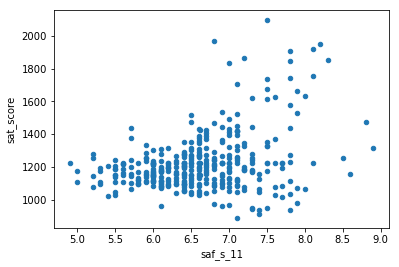

In [11]:
combined.plot.scatter("saf_s_11","sat_score")

### Analysis
There seems to be a large clcuster of students in the middle and a medium positive correlation for the rest of the points
# Mapping safety scores
Finding district averages

In [12]:
districts= combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace= True)


from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()

latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c= districts["ell_percent"], cmap= "summer")

plt.show()


ImportError: No module named 'mpl_toolkits.basemap'

### Analysis
Inner Brooklyn, lower Manhattan, parts of Queens and Staten Island seem to have the lowest scores for Safety and Respect, While Upper Manhattan, and parts of Brooklyn on the coast and near upper Manhattanhave some of the highest scores.

# Investigating Racial differences

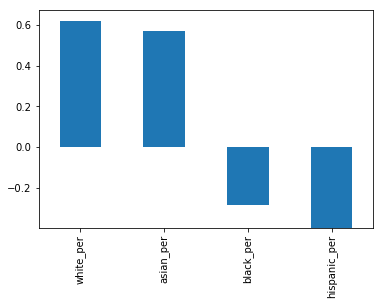

In [13]:
races = [
    "white_per",
    "asian_per",
    "black_per",
     "hispanic_per"
]

combined.corr()["sat_score"][races].plot.bar()

### Analysis
There seems to be strong positive correltions between the percentage of Asian or White students at a school and the SAT scores. There also seems to weak to medium negative correaltions between SAT scores and the percentages of black and Hispanic students. This is potentially indicative of racial disparities for SAT scores, but requires further investigation.
# Investigating hispanic percentages further

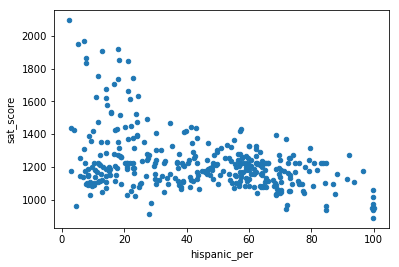

In [14]:
combined.plot.scatter("hispanic_per","sat_score")

Interestingly, the schools that have the highest hipspanic percentages have some of the worst SAT scores. And none of the highest scoring schools have hispanic percentages of higher than 25%.

In [15]:
hisp_95= combined[combined["hispanic_per"]>95]
print(hisp_95["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Analysis
From further research, it seems that the schools with the highest hispanic percentages seem to be schools geared towards students who recently immigrated from hispanic countries. Not being familiar with English would largely explain why students from thse schools don't fair well in the SATs

In [16]:
hisp_10= combined[(combined["hispanic_per"]<95)&(combined["sat_score"]>1800)]
print(hisp_10["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Analysis
The schools with high SAT scores with low hispanic percentage seem to be schools geared for Science/Math focused students or for students who seek our more academically challenging curriculum in preparation for college. This does explain why students do better in the SAT, which is a college prep. test and where half the scored is determined by mathematical problems

# Investigating gender differences

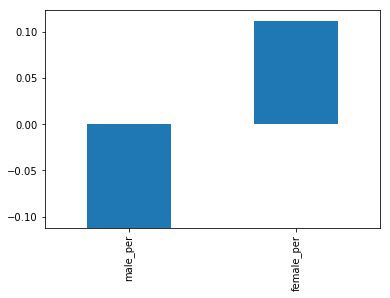

In [17]:
combined.corr()["sat_score"][["male_per","female_per"]].plot.bar()

### Analysis
There is a negative weak correlation between male percentage and SAT scores and a positive weak correlation between female percentage at a school and SAT scores

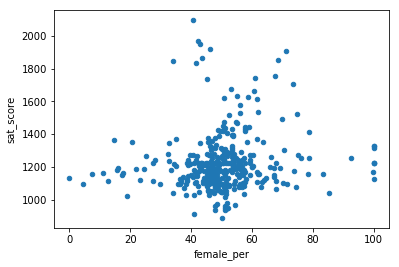

In [18]:
combined.plot.scatter("female_per","sat_score")

### Analysis
There doesn't seem to be any strongly discernible patter between female percentages and SAT scores, and there's a big cluster around the middle at 50%

In [19]:
fem_60= combined[(combined["female_per"]>60)&(combined["sat_score"]>1700)]
print(fem_60["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Analysis
All the schools that have morethan 60% women and high SAT scores seem to be selective schools

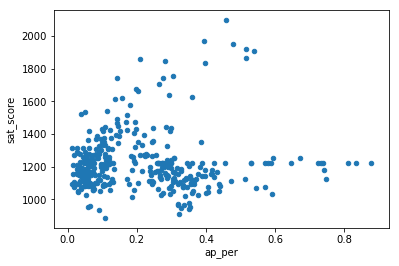

In [20]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter("ap_per", "sat_score")

### Analysis
There seems to be a large cluster of schools with the SAT scores aroun the 1200 mark. But excluding this cluster, the rest of the schools seem show a positive correlation between AP test-taker percentage and SAT Scores as the average SAT scores get higher